In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Loading train set from: ./jhu_crowd_v2.0/train
train batch shape: torch.Size([16, 1, 256, 256])
train crowd counts: tensor([ 15.,   8.,  87., 197., 204., 154.,  89.,  69.,  27.,  39.,  36.,  59.,
         61.,  27.,  14., 346.])

Loading val set from: ./jhu_crowd_v2.0/val
val batch shape: torch.Size([16, 1, 256, 256])
val crowd counts: tensor([804.,  41.,  26.,  31.,  40.,  35.,  96.,  32., 140., 210.,  90., 133.,
        144., 408.,  60.,  20.])

Loading test set from: ./jhu_crowd_v2.0/test
test batch shape: torch.Size([16, 1, 256, 256])
test crowd counts: tensor([ 43.,  59., 463., 299., 140.,  28.,  45.,  33.,  50.,  55., 284., 275.,
         52., 212., 134., 270.])


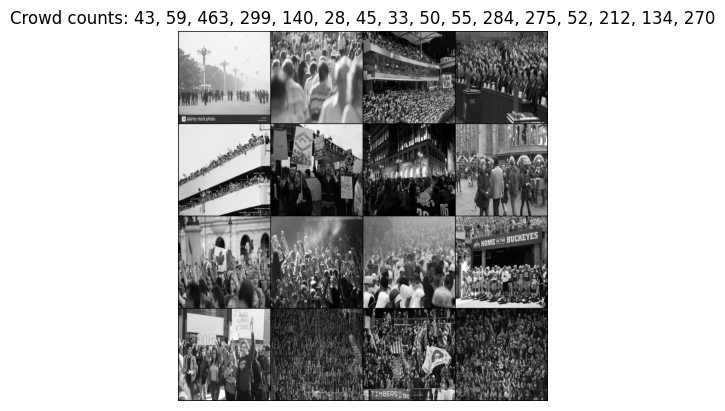


Loading train set from: ./jhu_crowd_v2.0/train
train batch shape: torch.Size([16, 1, 256, 256])
train crowd counts: tensor([ 31., 424., 316.,  15., 160., 246., 381., 146.,   7., 114., 187.,  85.,
        210.,   0.,  24.,  19.])

Loading val set from: ./jhu_crowd_v2.0/val
val batch shape: torch.Size([16, 1, 256, 256])
val crowd counts: tensor([804.,  41.,  26.,  31.,  40.,  35.,  96.,  32., 140., 210.,  90., 133.,
        144., 408.,  60.,  20.])

Loading test set from: ./jhu_crowd_v2.0/test
test batch shape: torch.Size([16, 1, 256, 256])
test crowd counts: tensor([ 43.,  59., 463., 299., 140.,  28.,  45.,  33.,  50.,  55., 284., 275.,
         52., 212., 134., 270.])
All crowd counts (comma-separated):
31,424,316,15,160,246,381,146,7,114,187,85,210,0,24,19,804,41,26,31,40,35,96,32,140,210,90,133,144,408,60,20,43,59,463,299,140,28,45,33,50,55,284,275,52,212,134,270


In [2]:
# Pre Processing

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CrowdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images_dir = os.path.join(data_dir, 'images')
        self.label_path = os.path.join(data_dir, 'image_labels.txt')
        self.transform = transform

        self.samples = []
        with open(self.label_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 2:
                    image_id = parts[0]
                    count = float(parts[1])
                    if count > 1000:
                        continue  # skip this image
                    filename = image_id + '.jpg'
                    self.samples.append((filename, count))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, count = self.samples[idx]
        image_path = os.path.join(self.images_dir, filename)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        count = torch.tensor(count, dtype=torch.float32)

        return image, count

# Shared preprocessing transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define paths to each data split
base_dir = './jhu_crowd_v2.0'
splits = {
    'train': os.path.join(base_dir, 'train'),
    'val': os.path.join(base_dir, 'val'),
    'test': os.path.join(base_dir, 'test')
}

# Load and preview each split
if __name__ == '__main__':
    for split_name, path in splits.items():
        print(f"\nLoading {split_name} set from: {path}")
        dataset = CrowdDataset(data_dir=path, transform=transform)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=(split_name == 'train'))

        for images, counts in dataloader:
            print(f"{split_name} batch shape:", images.shape)
            print(f"{split_name} crowd counts:", counts)
            break


# JUST TO VISUALIZE THAT ITS WORKING:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

# Show first N samples in a grid
N = 16
images = []
labels = []

for i in range(N):
    img, count = dataset[i]
    img = img * 0.5 + 0.5  # unnormalize
    images.append(img)
    labels.append(f"{int(count.item())}")

# Combine into a single grid
grid = make_grid(torch.stack(images), nrow=4, padding=2)
np_grid = TF.to_pil_image(grid)

plt.imshow(np_grid, cmap='gray')
plt.axis('off')
plt.title("Crowd counts: " + ", ".join(labels))
plt.show()


def export_tensor_dataset(dataset, output_path='tensor_dataset.pt'):
    data = []
    for img, count in dataset:
        data.append((img, torch.tensor(count)))  # convert count to tensor for consistency

    torch.save(data, output_path)

if __name__ == '__main__':
    all_counts = []

    for split_name, path in splits.items():
        print(f"\nLoading {split_name} set from: {path}")
        dataset = CrowdDataset(data_dir=path, transform=transform)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=(split_name == 'train'))

        for images, counts in dataloader:
            print(f"{split_name} batch shape:", images.shape)
            print(f"{split_name} crowd counts:", counts)
            all_counts.extend(counts.tolist())  # Collect counts

            break

    print("All crowd counts (comma-separated):")
    print(','.join(str(int(count)) for count in all_counts))

In [3]:
#Model Definition

import torchvision.models as models
import torch.nn as nn

class ResNetCrowdRegressor(nn.Module):
    def __init__(self):
        super(ResNetCrowdRegressor, self).__init__()
        from torchvision.models import resnet18, ResNet18_Weights
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

        # If using grayscale images, change first conv layer
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.backbone = nn.Sequential(*list(resnet.children())[:-3])  # remove avgpool + FC
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.3), # shouldn't happen if you're testing **** Mossa
        nn.Linear(128, 1)
    )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.fc(x)
        return x.squeeze(1)



In [4]:
import torch.nn as nn

class LogMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, target):
        eps = 1e-6  # small value to avoid log(0)
        log_pred = torch.log(prediction + eps)
        log_target = torch.log(target + eps)
        return nn.functional.mse_loss(log_pred, log_target)

In [5]:
from tqdm import tqdm

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    loop = tqdm(dataloader, desc="Training", leave=False)

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=loss.item())

    return running_loss / len(dataloader.dataset)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    loop = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())

    return total_loss / len(dataloader.dataset)


In [6]:
# Training loop
train_losses = []
val_losses = []
train_mse = []
val_mse = []

from tqdm import tqdm

# Load datasets
train_dataset = CrowdDataset(splits['train'], transform=transform)
val_dataset = CrowdDataset(splits['val'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Initialize model, loss, optimizer
model = ResNetCrowdRegressor().to(device)
criterion = torch.nn.L1Loss()  #  MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-6
)

# Training loop
num_epochs = 10
best_val_loss = float('inf')
patience = 3
min_delta = 0.001
patience_counter = 0


from tqdm import tqdm

train_losses = []
val_losses = []
train_mse = []
val_mse = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_mse = 0.0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for images, targets in train_loader_tqdm:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * images.size(0)
        epoch_train_mse += torch.mean((outputs - targets) ** 2).item() * images.size(0)

        train_loader_tqdm.set_postfix({'MAE': loss.item()})

    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    avg_train_mse = epoch_train_mse / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_mse = 0.0
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, targets in val_loader_tqdm:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)

            epoch_val_loss += loss.item() * images.size(0)
            epoch_val_mse += torch.mean((outputs - targets) ** 2).item() * images.size(0)

            val_loader_tqdm.set_postfix({'MAE': loss.item()})

    avg_val_loss = epoch_val_loss / len(val_loader.dataset)
    avg_val_mse = epoch_val_mse / len(val_loader.dataset)

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mse.append(avg_train_mse)
    val_mse.append(avg_val_mse)

    print(f"Train MAE: {avg_train_loss:.4f} | Val MAE: {avg_val_loss:.4f}")
    print(f"Train MSE: {avg_train_mse:.4f} | Val MSE: {avg_val_mse:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    scheduler.step(avg_val_loss)

    if patience_counter >= patience:
        print("Early stopping.")
        break

        print("Early stopping.")
        break



Epoch 1/10


Train MAE: 160.2076 | Val MAE: 130.8584
Train MSE: 60115.1267 | Val MSE: 50387.8903

Epoch 2/10


Train MAE: 111.2346 | Val MAE: 106.2832
Train MSE: 36802.3168 | Val MSE: 35221.0649

Epoch 3/10


Train MAE: 92.3242 | Val MAE: 85.0793
Train MSE: 23659.9614 | Val MSE: 24267.8620

Epoch 4/10


Train MAE: 88.3137 | Val MAE: 84.4388
Train MSE: 22180.5972 | Val MSE: 18885.3569

Epoch 5/10


Train MAE: 85.3222 | Val MAE: 88.1896
Train MSE: 20560.4029 | Val MSE: 26238.3163

Epoch 6/10


Train MAE: 84.0335 | Val MAE: 82.6957
Train MSE: 20038.9375 | Val MSE: 23107.5462

Epoch 7/10


Train MAE: 82.3857 | Val MAE: 82.6495
Train MSE: 19992.4514 | Val MSE: 17832.5935

Epoch 8/10


Train MAE: 82.0936 | Val MAE: 77.7093
Train MSE: 19516.2139 | Val MSE: 18016.3214

Epoch 9/10


Train MAE: 82.1185 | Val MAE: 73.7809
Train MSE: 19865.0376 | Val MSE: 15407.1998

Epoch 10/10


Train MAE: 80.5173 | Val MAE: 94.1968
Train MSE: 17971.2919 | Val MSE: 25459.9674


In [12]:
print("train_losses:", train_losses)
print("val_losses:", val_losses)
print("Number of epochs:", len(train_losses))


train_losses: []
val_losses: []
Number of epochs: 0


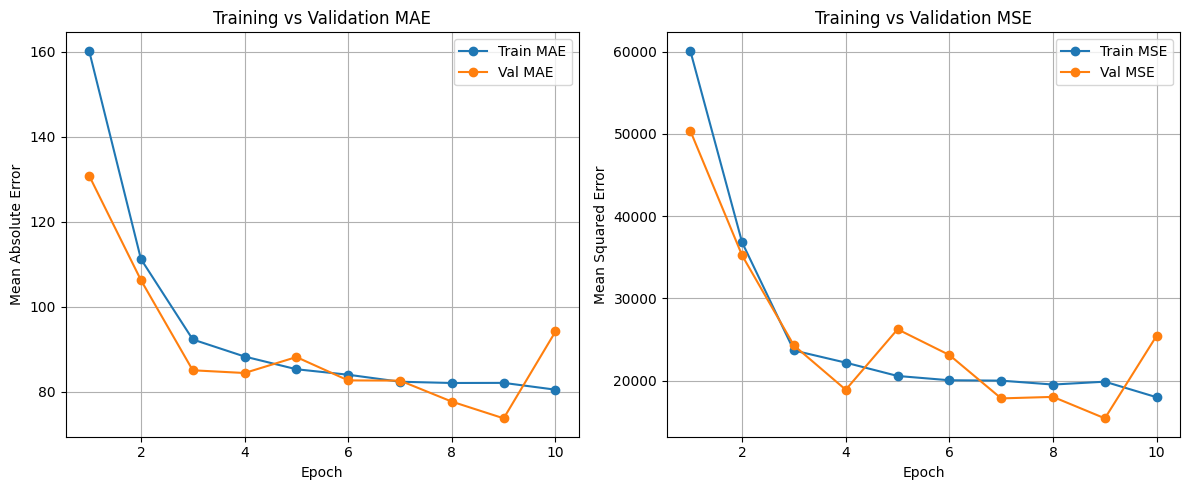

In [13]:
import matplotlib.pyplot as plt

# Data from your training log
epochs = list(range(1, 11))

train_mae = [160.2076, 111.2346, 92.3242, 88.3137, 85.3222, 84.0335, 82.3857, 82.0936, 82.1185, 80.5173]
val_mae   = [130.8584, 106.2832, 85.0793, 84.4388, 88.1896, 82.6957, 82.6495, 77.7093, 73.7809, 94.1968]

train_mse = [60115.1267, 36802.3168, 23659.9614, 22180.5972, 20560.4029, 20038.9375, 19992.4514, 19516.2139, 19865.0376, 17971.2919]
val_mse   = [50387.8903, 35221.0649, 24267.8620, 18885.3569, 26238.3163, 23107.5462, 17832.5935, 18016.3214, 15407.1998, 25459.9674]

# Plot
plt.figure(figsize=(12, 5))

# MAE
plt.subplot(1, 2, 1)
plt.plot(epochs, train_mae, marker='o', label='Train MAE')
plt.plot(epochs, val_mae, marker='o', label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.grid(True)
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(epochs, train_mse, marker='o', label='Train MSE')
plt.plot(epochs, val_mse, marker='o', label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation MSE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
test_dataset = CrowdDataset(splits['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16)

test_loss = evaluate_model(model, test_loader, criterion, device)
print(f"Test MAE: {test_loss:.4f}")

Test MAE: 107.4571


In [15]:
torch.save(model.state_dict(), 'final_model.pt')
print("Saved final model weights to 'final_model.pt'.")

Saved final model weights to 'final_model.pt'.


In [16]:
from PIL import Image
import torch

def predict_count_from_image(model, image_path, transform, device='cpu'):
    """
    Predict the crowd count for a single image.
    
    Args:
        model: Trained CNN model.
        image_path (str): Path to the image file.
        transform: The preprocessing transform used during training.
        device: 'cuda' or 'cpu'.
    
    Returns:
        float: Predicted crowd count.
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # add batch dimension

    with torch.no_grad():
        prediction = model(image)
        predicted_count = prediction.item()

    return predicted_count

In [42]:
test_image_path = "./jhu_crowd_v2.0/test6.jpeg"  # or any path
predicted = predict_count_from_image(model, test_image_path, transform, device)
print(f"Predicted Crowd Count: {predicted:.2f}")

Predicted Crowd Count: 67.56


In [43]:
from PIL import Image
from torchvision import transforms
import torch

# Path to test image
test_image_path = "./jhu_crowd_v2.0/test6.jpeg"  # update if needed

# Define the same preprocessing as training
inference_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def predict_count_from_image(model, image_path, transform, device):
    model.eval()
    with torch.no_grad():
        img = Image.open(image_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)  # [1, 1, 256, 256]
        output = model(input_tensor).squeeze().item()
    return output

# Make prediction
predicted = predict_count_from_image(model, test_image_path, inference_transform, device)
print(f"Predicted Crowd Count: {predicted:.2f}")


Predicted Crowd Count: 54.26


In [22]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

# Define the model class exactly as in training
class ResNetCrowdRegressor(nn.Module):
    def __init__(self):
        super(ResNetCrowdRegressor, self).__init__()
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Adjust for grayscale images
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.backbone = nn.Sequential(*list(resnet.children())[:-3])  # remove avgpool + FC
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.fc(x)
        return x.squeeze(1)

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetCrowdRegressor().to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()

# Define the same transform (for a single grayscale image)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure 1 channel
    transforms.Resize((224, 224)),  # Match input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you normalized around 0.5
])

# Load an image for inference
img_path = 'jhu_crowd_v2.0/test5.jpeg'  # Replace with your image path
image = Image.open(img_path).convert('RGB')  # Your image might be RGB, so convert properly
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    predicted_count = output.item()

print(f'Predicted Count: {predicted_count:.2f}')

# Interpret the result
if predicted_count < 50:
    print("Status: Empty")
elif predicted_count < 60:
    print("Status: A few people")
elif predicted_count < 70:
    print("Status: Average crowd")
elif predicted_count < 80:
    print("Status: Getting busy")
elif predicted_count < 100:
    print("Status: Busy")
else:
    print("Status: Packed")

Predicted Count: 32.89
Status: Empty


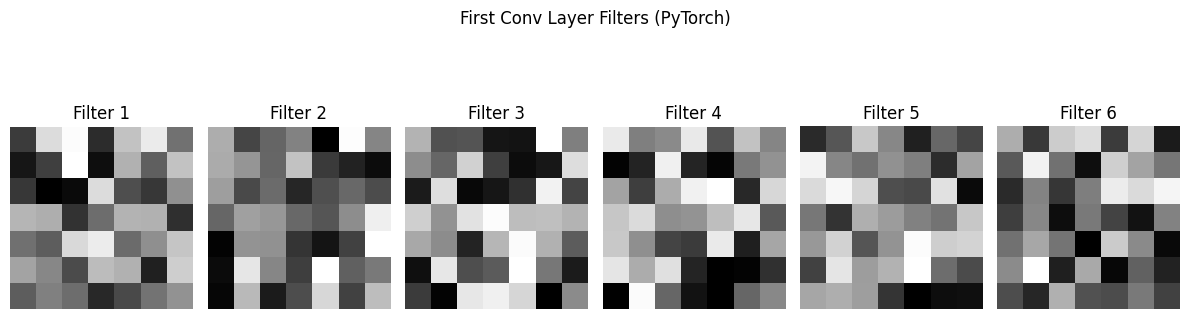

In [28]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Step 1: Navigate to the actual conv layer
# Assume model.features = nn.Sequential(...), common in custom ResNet-like models
first_conv = list(model.children())[0]  # this is likely a Sequential
first_conv_layer = None

# Find the first actual Conv2d layer inside that Sequential
for layer in first_conv:
    if isinstance(layer, torch.nn.Conv2d):
        first_conv_layer = layer
        break

if first_conv_layer is None:
    raise ValueError("Could not find a Conv2d layer in the model's first block.")

# Step 2: Extract weights
filters = first_conv_layer.weight.data.cpu().numpy()

# Step 3: Normalize for display
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = min(filters.shape[0], 6)
plt.figure(figsize=(12, 4))

for i in range(n_filters):
    filter_img = filters[i, 0]  # first channel of each filter
    plt.subplot(1, n_filters, i + 1)
    plt.imshow(filter_img, cmap='gray')
    plt.axis('off')
    plt.title(f'Filter {i+1}')

plt.suptitle("First Conv Layer Filters (PyTorch)")
plt.tight_layout()
plt.show()


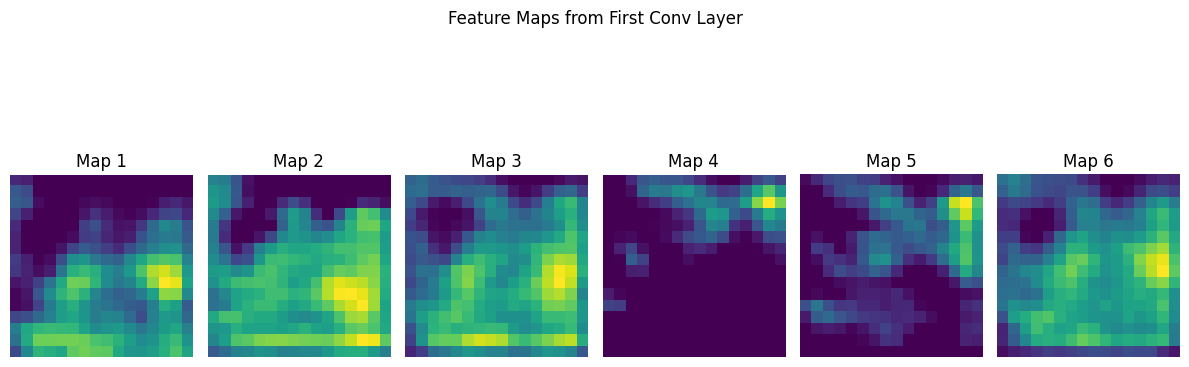

In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get a batch of validation data
model.eval()
images, _ = next(iter(val_loader))  # just get the images
image = images[0].unsqueeze(0).to(device)  # pick one image

# Hook to capture feature maps from the first conv layer
activations = {}

def hook_fn(module, input, output):
    activations['features'] = output.detach().cpu()

# Replace 'conv1' with the actual name of your first conv layer
first_conv = list(model.children())[0]  # this may need to change based on your model
hook = first_conv.register_forward_hook(hook_fn)

# Forward pass
with torch.no_grad():
    _ = model(image)

# Remove hook
hook.remove()

# Get activations and plot
feature_maps = activations['features'].squeeze(0)  # remove batch dim
num_features_to_show = min(6, feature_maps.shape[0])

plt.figure(figsize=(12, 5))
for i in range(num_features_to_show):
    plt.subplot(1, num_features_to_show, i + 1)
    plt.imshow(feature_maps[i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Map {i+1}')
plt.suptitle("Feature Maps from First Conv Layer")
plt.tight_layout()
plt.show()


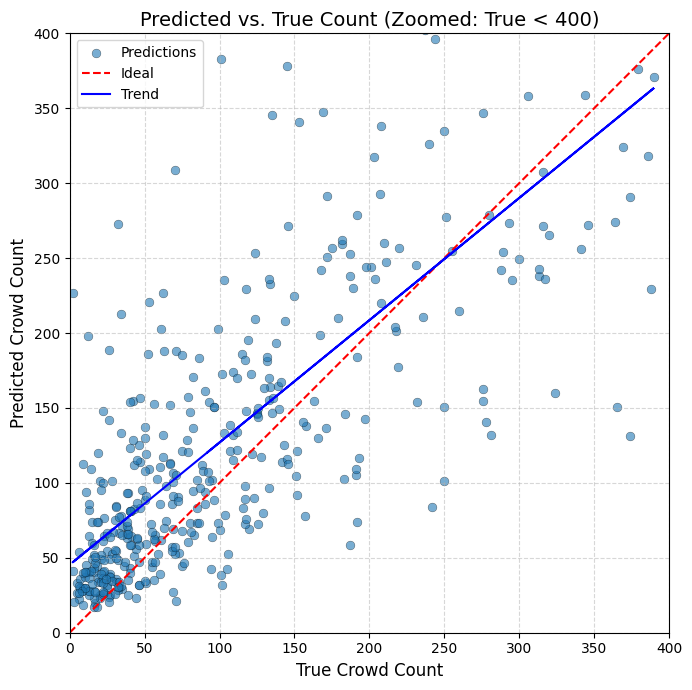

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Filter to only points with true count under 400
filtered_true = []
filtered_pred = []

for t, p in zip(true_counts, predicted_counts):
    if t < 400:
        filtered_true.append(t)
        filtered_pred.append(p)

# Convert to NumPy for better control
filtered_true = np.array(filtered_true)
filtered_pred = np.array(filtered_pred)

# Optional: Fit a trend line (linear regression)
slope, intercept = np.polyfit(filtered_true, filtered_pred, 1)
trend_line = slope * filtered_true + intercept

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(filtered_true, filtered_pred, alpha=0.6, s=40, edgecolor='k', linewidth=0.3, label='Predictions')
plt.plot([0, 400], [0, 400], 'r--', label='Ideal')  # identity line
plt.plot(filtered_true, trend_line, color='blue', linestyle='-', linewidth=1.5, label='Trend')

# Styling
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.xlabel("True Crowd Count", fontsize=12)
plt.ylabel("Predicted Crowd Count", fontsize=12)
plt.title("Predicted vs. True Count (Zoomed: True < 400)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
plt.show()


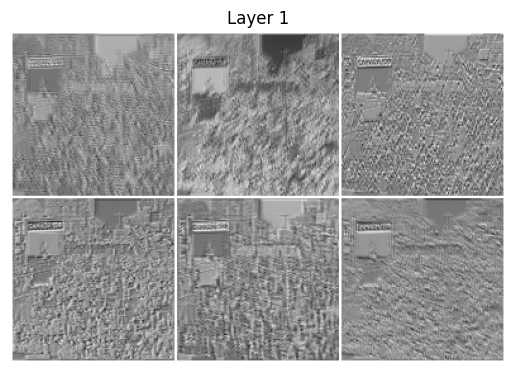

In [60]:
import torch
import matplotlib.pyplot as plt
import imageio
import os
import numpy as np
from torchvision.utils import make_grid
from PIL import Image  # Ensure this is the correct PIL.Image
from IPython.display import Image as IPImage, display

# === 1. Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
os.makedirs("activation_frames", exist_ok=True)

# === 2. Get one image from the validation set ===
sample_img, _ = next(iter(val_loader))  # shape: [B, C, H, W]
sample_img = sample_img[0].unsqueeze(0).to(device)  # shape: [1, C, H, W]

# === 3. Flatten top-level layers ===
layers = []
for module in model.children():
    if isinstance(module, torch.nn.Sequential):
        layers.extend(module.children())
    else:
        layers.append(module)

# === 4. Forward pass layer by layer ===
x = sample_img
for i, layer in enumerate(layers):
    x = layer(x)
    activations = x.detach().cpu()[0][:6]  # take first 6 feature maps (shape: [6, H, W])

    # Create a grid
    grid = make_grid(activations.unsqueeze(1), nrow=3, normalize=True, pad_value=1)
    npimg = grid.cpu().numpy()

    # Convert to (H, W) or (H, W, C) as needed
    if npimg.ndim == 3:
        if npimg.shape[0] == 1:  # grayscale
            npimg = npimg[0]
        elif npimg.shape[0] == 3:  # RGB
            npimg = np.transpose(npimg, (1, 2, 0))
        else:  # more channels (e.g., 6), average to 2D
            npimg = np.mean(npimg, axis=0)

    # Save plot
    fig, ax = plt.subplots()
    ax.imshow(npimg, cmap='viridis')
    ax.set_title(f"Layer {i+1}")
    ax.axis('off')
    frame_path = f"activation_frames/layer_{i:02d}.png"
    plt.savefig(frame_path, bbox_inches='tight')
    plt.close()

# === 5. Create GIF ===
frame_paths = sorted([f"activation_frames/{f}" for f in os.listdir("activation_frames") if f.endswith(".png")])

from PIL import Image as PILImage

# Resize all frames to the same size (e.g., the first frame's size)
base_size = PILImage.open(frame_paths[0]).size  # (width, height)
images = []

for path in frame_paths:
    img = PILImage.open(path).convert("RGB").resize(base_size)
    images.append(np.array(img))

gif_path = "activation_evolution.gif"
imageio.mimsave(gif_path, images, duration=0.8)

# === 6. Display in notebook ===
display(IPImage(filename=gif_path))
